<h1>Оператор связи «ТелеДом»<span class="tocSkip"></span></h1>

# Содержание
1. [Загрузка данных](#Загрузка-данных)
2. [Исследовательский анализ и предобработка данных](#Исследовательский-анализ-и-предобработка-данных)
3. [Объединение данных](#Объединение-данных)
4. [Исследовательский анализ и предобработка данных объединённого датафрейма](#Исследовательский-анализ-и-предобработка-данных-объединённого-датафрейма)
5. [Подготовка данных](#Подготовка-данных)
6. [Обучение моделей машинного обучения](#Обучение-моделей-машинного-обучения)
7. [Выбор лучшей модели](#Выбор-лучшей-модели)
8. [Общий вывод и рекомендации заказчику](#Общий-вывод-и-рекомендации-заказчику)

# Описание проекта


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. **Задача: обучить на этих данных модель для прогноза оттока клиентов**


**Описание услуг**

Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

1. contract_new.csv — информация о договоре;
2. personal_new.csv — персональные данные клиента;
3. internet_new.csv — информация об интернет-услугах;
4. phone_new.csv — информация об услугах телефонии.

*Файл contract_new.csv*
* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

*Файл personal_new.csv*
* customerID — идентификатор пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

*Файл internet_new.csv*
* customerID — идентификатор пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

*Файл phone_new.csv*
* customerID — идентификатор пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

# Импортирование и установка библиотек

In [ ]:
!pip install phik --q
!pip install catboost --q
!pip install shap --q
!pip install tensorflow==2.7.0 --q

In [ ]:
pip install -U scikit-learn

     |████████████████████████████████| 12.2 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 94.2 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from time import time
from datetime import timedelta, datetime
import warnings

import catboost
import re
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
from phik.report import plot_correlation_matrix
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    roc_curve,
    ConfusionMatrixDisplay,
    auc,
    confusion_matrix
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

RANDOM_STATE = 80424
TEST_SIZE = 0.25

warnings.filterwarnings('ignore')

2024-04-16 14:29:49.437849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-16 14:29:49.437895: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Методы для работы

**Метод для преобразования строки в snake_case**

In [ ]:
def to_snake_case(s):
    return '_'.join(re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', s.replace('-', ' '))).split()).lower()

**Метод для построения графиков датасета df_contract**

In [ ]:
def create_df_contract(data, column, chart_type, bins=100, color='blue', alpha=0.5, edge_color='black', edge_width=1.2, rotation=45):
    # Разделение данных по столбцу 'churn'
    data_no_churn = data[data['churn'] == 'No']
    data_yes_churn = data[data['churn'] == 'Yes']

    if chart_type == "hist":
        # Создание гистограммы, где два распределения накладываются друг на друга
        plt.figure(figsize=(12, 6))

        # Гистограмма для клиентов без оттока
        plt.hist(data_no_churn[column], bins=bins, color='blue', alpha=alpha, edgecolor=edge_color, linewidth=edge_width, label='Остались')

        # Гистограмма для клиентов с оттоком
        plt.hist(data_yes_churn[column], bins=bins, color='red', alpha=alpha, edgecolor=edge_color, linewidth=edge_width, label='Ушли')

        plt.title(f'Признак {column} - Частота распределения', fontsize=18)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.grid(True)
        plt.legend()

    elif chart_type == "barplot":
        # Создание столбчатых диаграмм
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

        sns.countplot(x=column, data=data_no_churn, ax=axes[0], palette='Blues')
        axes[0].set_title('Остались')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel("Количество")
        axes[0].tick_params(axis='x', rotation=rotation)

        sns.countplot(x=column, data=data_yes_churn, ax=axes[1], palette='Reds')
        axes[1].set_title('Ушли')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel("Количество")
        axes[1].tick_params(axis='x', rotation=rotation)

        plt.suptitle(f'Признак {column} - Частота распределения', fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    elif chart_type == "pie":
        # Создание круговых диаграмм
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        for ax, dataset, title in zip(axes, [data_no_churn, data_yes_churn], ['Остались', 'Ушли']):
            category_counts = dataset[column].value_counts()
            ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
            ax.set_title(title)
        plt.suptitle(f'Круговая диаграмма для признака {column}', fontsize=18)

    elif chart_type == "boxplot":
        # Создание ящиков с усами
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        for ax, dataset, title in zip(axes, [data_no_churn, data_yes_churn], ['Остались', 'Ушли']):
            sns.boxplot(x=column, data=dataset, ax=ax, color=color)
            ax.set_title(title)
            ax.set_xlabel(column)
            ax.set_ylabel("Значения")
        plt.suptitle(f'Ящик с усами для признака {column}', fontsize=18)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

**Метод для построения графиков других датасетов**

In [ ]:
def create(data, column, type, bins = 100, color = 'blue', alpha = 0.5, edge_color='black', edge_width=1.2, rotation = 45):
    category_counts = data[column].value_counts()
    if type == "hist":
        """
        Создает гистограмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(12, 6))
        plt.hist(data=data, x=column, bins=bins, color=color, alpha=alpha, edgecolor=edge_color, linewidth=edge_width)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Призак {column} - Частота распределения', fontsize=18)
        plt.grid(True)
        plt.show()
    elif type == "barplot":
        """
        Создает столбчатую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(10, 6))
        plt.xticks(rotation=rotation)
        new_data = data[column].value_counts()
        df_new_data = new_data.reset_index()
        df_new_data.columns = [column, 'count']

        sns.barplot(x=column, y='count', data = df_new_data)
        plt.title(f'{column}.Частота распределения')
        plt.xlabel(f'{column}')
        plt.ylabel(f'количество')
    elif type == "pie":
        """
        Создает круговую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(8, 8))
        plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Круговая диаграмма для {column}', fontsize=18)
        plt.show()
    elif type == "boxplot":
        """
        Создает ящик с усами для заданного столбца DataFrame.
        """
        plt.figure(figsize=(10, 6))
        plt.boxplot(data[column], notch=True, patch_artist=True, boxprops=dict(facecolor=color, color=edge_color),
                    whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color),
                    medianprops=dict(color=edge_color), flierprops=dict(markeredgecolor=edge_color, markerfacecolor=color))
        plt.ylabel("Значения")
        plt.xlabel(column)
        plt.title(f'Ящик с усами для признака {column}', fontsize=18)
        plt.grid(True)
        plt.show()

**Метод для просмотра уникальных значений признака**

In [ ]:
def uniqueness(df, column_list):
    '''
    Просмотр уникальных значений листа
    '''
    for column in column_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print('-----------------------------')

**Метод для построения графиков объединённого датасета**

In [ ]:
def proba_plot(data, column):
    # Собираем уникальные значения и их статистику по оттоку клиентов
    group_data = data.groupby([column, 'churn']).size().unstack(fill_value=0)
    totals = group_data.sum(axis=1)
    probas = group_data.div(totals, axis=0).round(2)

    # Подготовка DataFrame для визуализации
    plot_data = (probas.stack()
                .reset_index()
                .rename(columns={0: 'Доля клиентов', 'churn': 'Состояние клиента'})
                .replace({'Состояние клиента': {0: 'Не ушёл', 1: 'Ушёл'}}))

    # Визуализация данных
    sns.barplot(data=plot_data, x=column, y='Доля клиентов', hue='Состояние клиента', palette='Set2')
    plt.title('Распределение долей клиентов по категориям ' + column)
    plt.xticks(rotation=45)
    plt.show()

    # Подсчет и вывод корреляции Phik
    if 'phik_overview' in globals():
        phik_corr = np.round(phik_overview.loc[column, 'churn'], 2)
        print('Корреляция Phik:', phik_corr)
    else:
        print('phik_overview не определен в глобальном пространстве.')

    print('-----------------------------------------------------------------------------------------------')
    print()

**Метод для оценки корелляции целевого признака и числовых**

In [ ]:
def plot_correlation_with_target(df, target_feature):
    # Копирование DataFrame для безопасности
    data = df.copy()

    # Преобразование целевого признака в числовой вид, если он не числовой
    if data[target_feature].dtype == 'object':
        data[target_feature] = data[target_feature].astype('category').cat.codes

    # Выборка числовых признаков
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

    # Вычисление матрицы корреляции
    correlation_matrix = data[numeric_columns].corrwith(data[target_feature])

    # Визуализация корреляций
    plt.figure(figsize=(8, 5))
    sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index)
    plt.title('Корреляция с ' + target_feature)
    plt.xlabel('Коэффициент корреляции')
    plt.ylabel('Признаки')
    plt.show()

**Метод для создания признака 'bays_before_payment'**

In [ ]:

def days_before_payment_calculate(row):
    """
    Рассчитывает количество дней до следующей оплаты на основе использованных дней и типа оплаты.
    Параметры:
    row: dict - словарь с ключами 'type', 'begin_date', где
        'type' - тип оплаты, например 'Month-to-month', 'One year', 'Two year'
        'begin_date' - дата начала контракта типа Timestamp
    """
    start_date = row['begin_date']
    today_date = datetime.now().date()

    if row['type'] == 'Month-to-month':
        next_payment_date = start_date + timedelta(days=30)  # Предполагаем, что оплата каждые 30 дней
        while next_payment_date.date() <= today_date:
            next_payment_date += timedelta(days=30)
        return (next_payment_date.date() - today_date).days

    elif row['type'] == 'One year':
        next_payment_date = start_date + timedelta(days=365)  # Предполагаем, что оплата каждый год
        while next_payment_date.date() <= today_date:
            next_payment_date += timedelta(days=365)
        return (next_payment_date.date() - today_date).days

    elif row['type'] == 'Two year':
        next_payment_date = start_date + timedelta(days=730)  # Предполагаем, что оплата каждые два года
        while next_payment_date.date() <= today_date:
            next_payment_date += timedelta(days=730)
        return (next_payment_date.date() - today_date).days

    return None  # Если тип оплаты не поддерживается


## Загрузка данных

### Загрузка файлов и их первичный осмотр

In [ ]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
except FileNotFoundError:
    print('Файл contract_new.csv не найден')

try:
    df_personal = pd.read_csv('/datasets/personal_new.csv')
except FileNotFoundError:
    print('Файл personal_new.csv не найден')

try:
    df_internet = pd.read_csv('/datasets/internet_new.csv')
except FileNotFoundError:
    print('Файл internet_new.csv не найден')

try:
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except FileNotFoundError:
    print('Файл phone_new.csv не найден')

**Вывод общей информации датасетов и первых 5 строк.**

In [ ]:
# Список датафреймов и их названий
datasets = [
    ("contract_new.csv", df_contract),
    ("personal_new.csv", df_personal),
    ("internet_new.csv", df_internet),
    ("phone_new.csv", df_phone),
]

# Цикл для вывода информации и первых пяти строк каждого датафрейма
for name, df in datasets:
    print(f'\nДатасет {name}:')
    df.info()
    display(df.sample(5))


Датасет contract_new.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7009,7703-ZEKEF,2017-11-01,No,Month-to-month,Yes,Electronic check,81.00,2252.61
3700,5616-PRTNT,2018-03-01,No,Month-to-month,Yes,Electronic check,19.40,459.59
2880,2187-PKZAY,2019-02-01,No,Month-to-month,Yes,Bank transfer (automatic),79.95,997.78
1574,5312-TSZVC,2018-11-01,No,One year,No,Mailed check,19.65,297.7
4474,1139-WUOAH,2015-05-01,No,Two year,No,Credit card (automatic),53.35,3040.95



Датасет personal_new.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
2269,0151-ONTOV,Female,0,No,No
6349,3451-VAWLI,Female,0,Yes,Yes
2175,7927-AUXBZ,Female,0,No,No
5033,7298-IZWLY,Female,0,No,No
5388,5515-IDEJJ,Male,0,Yes,Yes



Датасет internet_new.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3597,0813-TAXXS,DSL,No,No,Yes,No,Yes,Yes
172,0230-WEQUW,DSL,Yes,Yes,Yes,Yes,Yes,No
1000,7595-EUIVN,Fiber optic,No,Yes,No,No,No,No
931,9127-FHJBZ,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
260,9880-TDQAC,DSL,No,Yes,Yes,Yes,Yes,Yes



Датасет phone_new.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
2756,6127-ISGTU,Yes
3701,0916-QOFDP,Yes
2398,3130-ICDUP,Yes
2289,9668-PUGNU,Yes
5974,7729-JTEEC,No


### Промежуточный вывод по загрузке данных

Файлы были успешно загружены и изучены.
1. *contract_new.csv:* В этом датасете 7043 строки, нет пропущенных значений в данных, что указывает на полную заполненность таблицы. Тип данных для MonthlyCharges — вещественные числа, что подходит для финансовой информации, а остальные колонки содержат текстовые данные (object).

2. *personal_new.csv:* Здесь также 7043 строки, что совпадает с первым датасетом, возможно, данные связаны по customerID. Нет пропусков в данных, колонка SeniorCitizen представлена целыми числами (int64).

3. *internet_new.csv:* Этот датасет содержит меньше записей — 5517 строк, и, как и в предыдущих, нет пропущенных значений. Все колонки представлены текстовыми данными. Возможно, не все клиенты из первых двух датасетов используют интернет-услуги, отсюда и разница в количестве строк.

4. *phone_new.csv:* Здесь 6361 запись, и также отсутствуют пропущенные значения. Все данные текстовые.

Чтобы определить наличие дубликатов и связь между таблицами, следует проверить значения customerID на уникальность в каждом датасете. Если customerID повторяются, это могут быть дубликаты, которые необходимо будет обработать.

Также, в каждом из датасетов нужно привести названия столбцов к единому стилю и поменять типы данных в некоторых признаках.

## Исследовательский анализ и предобработка данных

### Общая предобработка данных перед исследовательским анализом и предобработки данных конкретного датасета

**Приведём названия столбцов к единому стилю**

In [ ]:
for name, df in datasets:
    df.columns = [to_snake_case(c) for c in df.columns]

# Вывод информации по каждому датасету
for name, df in datasets:
    print(f"Название датасета: {name}\nНазвания признаков:")
    for column in df.columns:
        print(column)
    print()

Название датасета: contract_new.csv
Названия признаков:
customer_id
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Название датасета: personal_new.csv
Названия признаков:
customer_id
gender
senior_citizen
partner
dependents

Название датасета: internet_new.csv
Названия признаков:
customer_id
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies

Название датасета: phone_new.csv
Названия признаков:
customer_id
multiple_lines



**При выполнении проекта были замечены строки в которых total_charges равен пустой строке. Внимательно изучим их**

In [ ]:
display(df_contract[df_contract['total_charges'] == ' '])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Эти пользователи только зарегестрировались, поэтому у них еще нет никаких расходов. Заменим пустую строку на 0.

In [ ]:
df_contract['total_charges'] = df_contract['total_charges'].replace(' ', 0)

Проверим.

In [ ]:
display(df_contract[df_contract['total_charges'] == 0])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0


**Прежде чем поменять типы данных в столбцах, создадим столбец с клиентами, которые ушли или нет. Назовём его 'churn' (отток)**

In [ ]:
def list_comp(df):
    return df.assign(churn=['No' if x == 'No' else 'Yes' for x in df['end_date']])

df_contract = list_comp(df_contract)

**Проверим, добавился ли столбец**

In [ ]:
display(df_contract.sample(5))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
865,3671-SHRSP,2019-08-01,No,Month-to-month,Yes,Mailed check,80.60,488.44,No
5311,8053-WWDRO,2019-07-01,No,Month-to-month,No,Bank transfer (automatic),19.50,136.5,No
1380,1131-SUEKT,2015-01-01,No,One year,Yes,Bank transfer (automatic),98.45,6305.72,No
3471,1293-HHSHJ,2017-03-01,No,One year,No,Mailed check,21.10,797.58,No
4596,2432-TFSMK,2018-08-01,No,One year,Yes,Credit card (automatic),89.60,1612.8,No


**Изменим тип данных в датасете df_contract в признаке total_charges на вещественный.**

**Также, нужно поменять тип данных в столбце begin_date и end_date на временной, но в столбце end_date есть значения 'No' помимо даты. Так как информация о договорах актуальна на 1 февраля 2020 года, заменим в датасете df_contract в признаке end_date значения 'No' на '2020-02-01'**

In [ ]:
# Изменение типа данных столбца total_charges
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'])

# Изменение типа данных столбцов begin_date и end_date
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])

df_contract['end_date'] = df_contract['end_date'].replace('No', '2020-02-01')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

print(f"Тип данных в столбце total_charges: {df_contract['total_charges'].dtypes}\n"
      "---------------------------------------------\n"
      f"Тип данных в столбце begin_date: {df_contract['begin_date'].dtypes}\n"
      "---------------------------------------------\n"
      f"Тип данных в столбце end_date: {df_contract['end_date'].dtypes}")

Тип данных в столбце total_charges: float64
---------------------------------------------
Тип данных в столбце begin_date: datetime64[ns]
---------------------------------------------
Тип данных в столбце end_date: datetime64[ns]


**Обработка дубликатов**

In [ ]:
for data_name, df in datasets:
    if df.duplicated().sum() > 0:
        print(f'Дубликаты в {data_name}:')
        display(df[df.duplicated()])
    else:
        print(f'Дубликаты в {data_name} отсутствуют')

Дубликаты в contract_new.csv отсутствуют
Дубликаты в personal_new.csv отсутствуют
Дубликаты в internet_new.csv отсутствуют
Дубликаты в phone_new.csv отсутствуют


**Явных дубликатов не обнаружено, проверим уникальные значения в столбце customer_id для каждого из датасетов.**

In [ ]:
for data_name, df in datasets:
    unique_ids_count = df['customer_id'].nunique()
    total_rows = len(df)
    if unique_ids_count == total_rows:
        print(f'В {data_name} количество уникальных customer_id ({unique_ids_count}) совпадает с количеством строк ({total_rows}).')
    else:
        difference = total_rows - unique_ids_count
        print(f'В {data_name} количество уникальных customer_id ({unique_ids_count}) меньше количества строк ({total_rows}) на {difference}.')

В contract_new.csv количество уникальных customer_id (7043) совпадает с количеством строк (7043).
В personal_new.csv количество уникальных customer_id (7043) совпадает с количеством строк (7043).
В internet_new.csv количество уникальных customer_id (5517) совпадает с количеством строк (5517).
В phone_new.csv количество уникальных customer_id (6361) совпадает с количеством строк (6361).


**Посмотрим на пропуски**

In [ ]:
datasets = [
    ("contract_new.csv", df_contract),
    ("personal_new.csv", df_personal),
    ("internet_new.csv", df_internet),
    ("phone_new.csv", df_phone),
]
for name, df in datasets:
    print(f"Dataset: {name}")
    print(df.isnull().sum())
    print()

Dataset: contract_new.csv
customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

Dataset: personal_new.csv
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Dataset: internet_new.csv
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Dataset: phone_new.csv
customer_id       0
multiple_lines    0
dtype: int64



*Выполним исследовательский анализ и предобработку данных для каждого из датасетов.*

### Датасет df_contract

#### Исследовательский анализ датасета df_contract

Создание описательной статистики.

In [ ]:
display(df_contract.describe().T)

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38


Вывод уникальных значений признаков.

In [ ]:
uniqueness(df_contract, df_contract.columns.drop({'customer_id',
                                                  'monthly_charges',
                                                  'total_charges',
                                                  'begin_date',
                                                  'end_date'}))

Количество уникальных значений столбца type: 3
['Month-to-month' 'One year' 'Two year']
-----------------------------
Количество уникальных значений столбца paperless_billing: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца payment_method: 4
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
-----------------------------
Количество уникальных значений столбца churn: 2
['No' 'Yes']
-----------------------------


Визуализация данных с помощью графиков.

**Признак 'monthly_charges'**

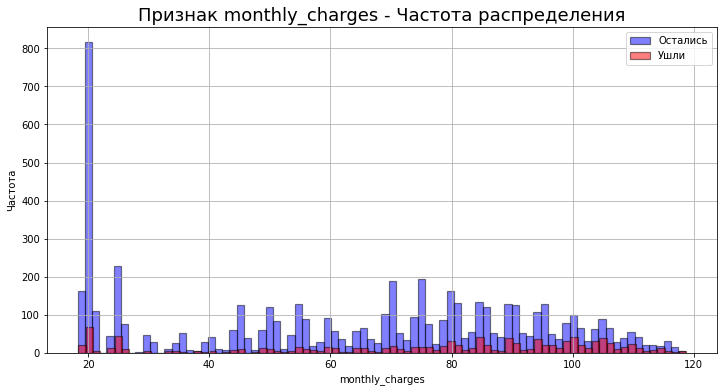

In [ ]:
create_df_contract(df_contract, 'monthly_charges', 'hist', bins = 84)

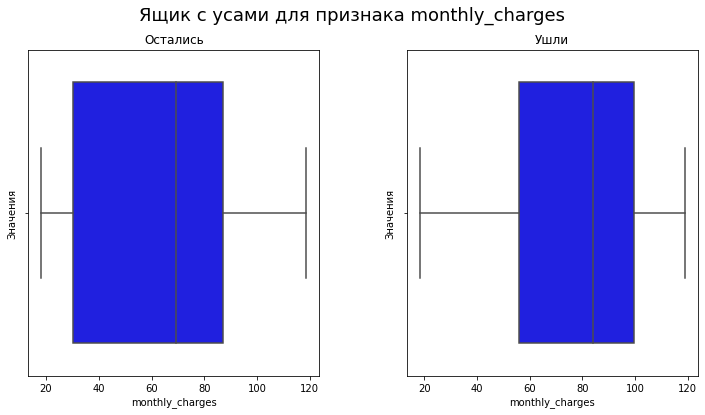

In [ ]:
create_df_contract(df_contract, 'monthly_charges', 'boxplot')

Гистограмма показывает, что наибольшее количество наблюдений сосредоточено в первом столбце. Также видны другие, меньшие пики, распределенные примерно равномерно на протяжении всего диапазона значений. Из графика видно, что среди тех, кто платит меньше, большее количество людей осталось.

Медиана среди ушедших клиентов, кажется, выше, чем среди тех, кто остался, что подтверждает наблюдение о том, что более высокие ежемесячные платежи коррелируют с уходом клиентов. Усы ящика также показывают, что среди ушедших клиентов есть большее распределение ежемесячных платежей

Выбросы отсутствуют, аномальных значений не наблюдается.

**Признак 'total_charges'**

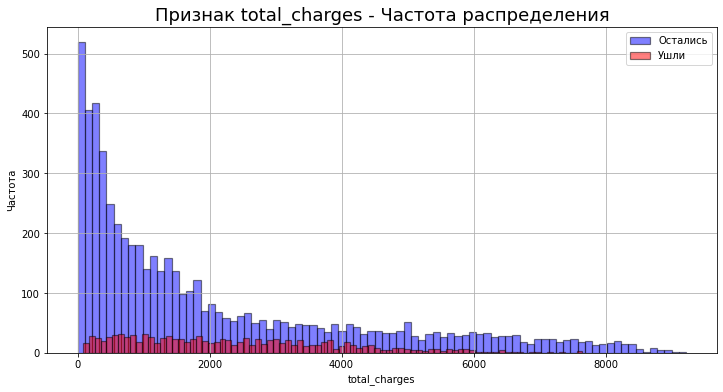

In [ ]:
create_df_contract(df_contract, 'total_charges', 'hist', bins = 84)

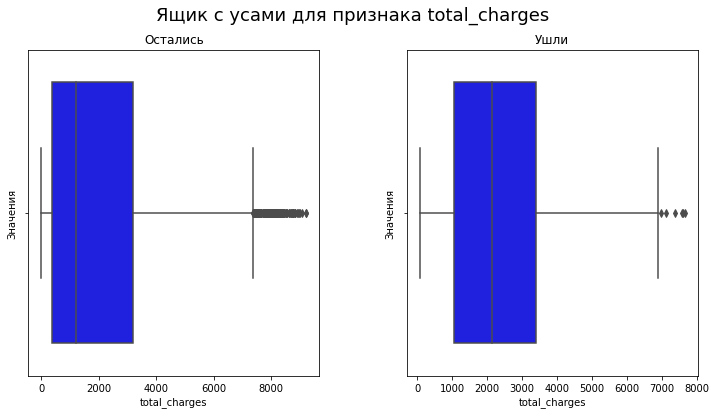

In [ ]:
create_df_contract(df_contract, 'total_charges', 'boxplot')

Большое количество клиентов с низкими общими платежами остались, в то время как ушедшие клиенты распределены более равномерно по различным уровням общих платежей.

Можно заметить, что ящик для группы ушедших клиентов смещен вправо, что указывает на более высокие общие платежи в сравнении с оставшимися клиентами. Также заметно, что у ушедших клиентов есть выбросы с очень высокими общими платежами.

Выбросы удалять не будем из-за того, что модель может недообучиться.

**Признак 'type'**

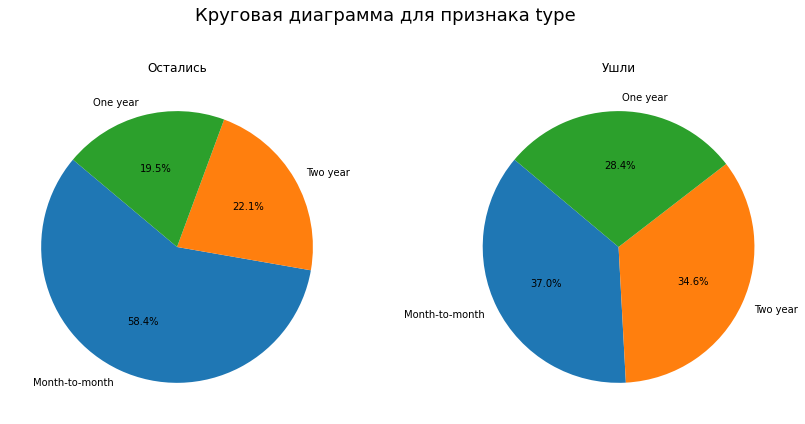

In [ ]:
create_df_contract(df_contract, 'type', 'pie')

1. Для оставшихся клиентов:
* Большинство (58.5%) находятся на месячном контракте (Month-to-month).
* Примерно пятая часть (22.0%) имеют двухгодичный контракт (Two year).
* Оставшиеся 19.5% имеют одногодичный контракт (One year).
2. Для ушедших клиентов:
* Самая большая доля (37.0%) также находится на месячном контракте.
* Немного меньшее количество ушедших клиентов имели двухгодичные (34.6%) и одногодичные контракты (28.4%).

**Признак 'PaymentMethod'**

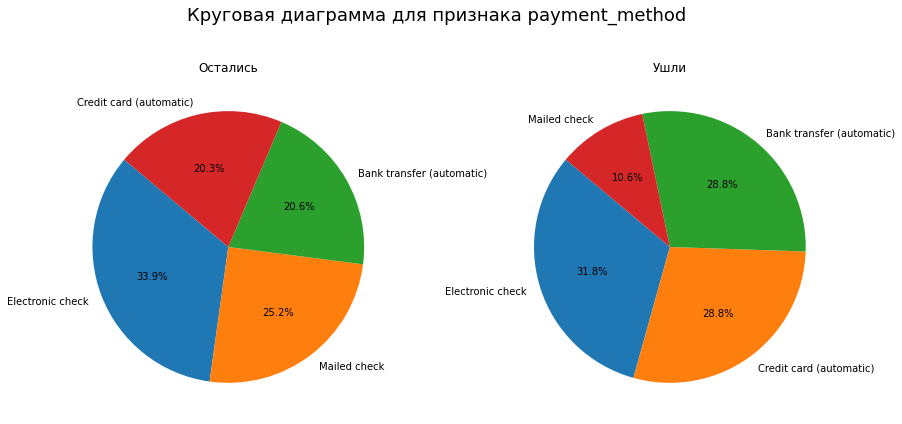

In [ ]:
create_df_contract(df_contract, 'payment_method', 'pie')

1. Для оставшихся клиентов:
* Самый популярный метод оплаты — это электронный чек (34.0%).
* Почти равные доли клиентов предпочли автоматические банковские переводы (20.7%) и автоматические платежи с кредитной карты (20.3%).
* Оплата чеком по почте использовалась в 25.1% случаев.
2. Для ушедших клиентов:
* Электронный чек также является наиболее частым выбором (31.8%), но его доля выше, чем среди оставшихся.
* Автоматический банковский перевод выбрали 28.8%, что также больше, чем среди оставшихся.
* Платежи автоматическими кредитными картами и чеками по почте составляют 28.8% и 10.6% соответственно.

**Признак 'churn'**

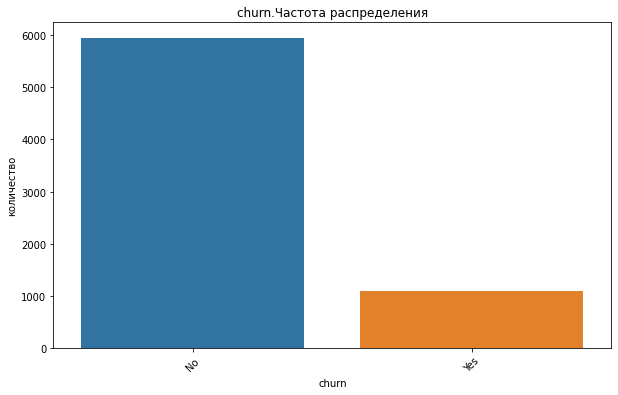

In [ ]:
create(df_contract, 'churn', 'barplot')

Значительно больше клиентов остались, чем ушли, что видно по высоте столбцов.

### Датасет df_personal

In [ ]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### Предобработка данных датасета df_personal

Поменяем тип данных в столбце senior_citizen с int64 на object

In [ ]:
df_personal.loc[df_personal['senior_citizen'] == 0, 'senior_citizen'] = 'No'
df_personal.loc[df_personal['senior_citizen'] == 1, 'senior_citizen'] = 'Yes'

print('Тип данных в столбце senior_citizen:', df_personal['senior_citizen'].dtype)

Тип данных в столбце senior_citizen: object


Вывод уникальных значений признаков.

In [ ]:
uniqueness(df_personal, df_personal.columns.drop('customer_id'))

Количество уникальных значений столбца gender: 2
['Female' 'Male']
-----------------------------
Количество уникальных значений столбца senior_citizen: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца partner: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца dependents: 2
['No' 'Yes']
-----------------------------


#### Исследовательский анализ датасета df_personal

**Признак 'gender'**

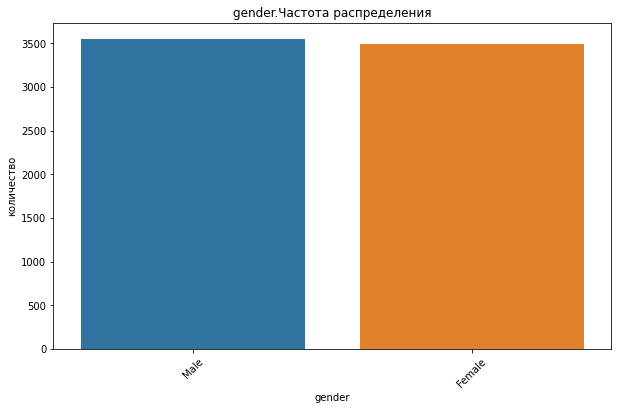

In [ ]:
create(df_personal, 'gender', 'barplot')

Количество представителей обоих полов почти одинаково, без значительного перевеса в сторону какого-либо из полов.

**Признак 'senior_citizen'**

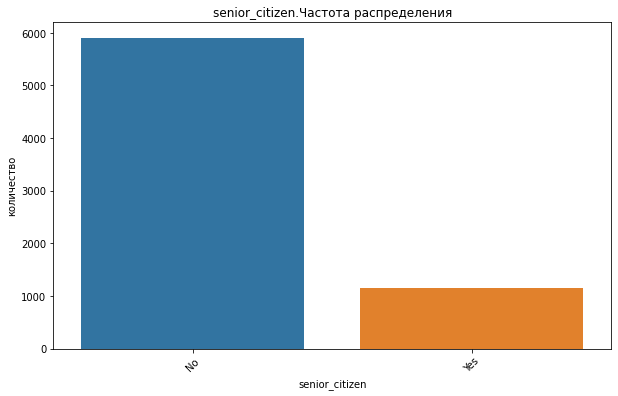

In [ ]:
create(df_personal, 'senior_citizen', 'barplot')

Столбец "No" значительно выше, что говорит о том, что в данном наборе данных пожилые граждане составляют меньшинство.

**Признак 'partner'**

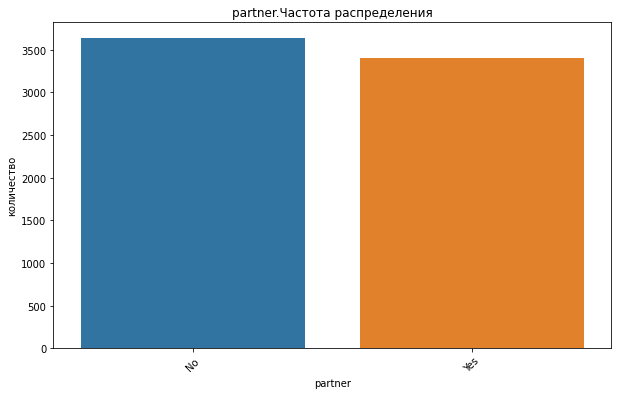

In [ ]:
create(df_personal, 'partner', 'barplot')

Столбец "No" (нет партнера) немного выше, чем столбец "Yes" (есть партнер).

**Признак 'dependents'**

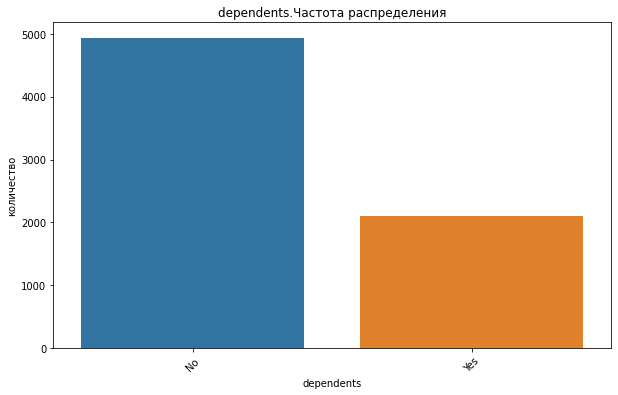

In [ ]:
create(df_personal, 'dependents', 'barplot')

Столбец "No" значительно выше, что указывает на то, что большинство людей в датасете не имеют детей.

### Датасет df_internet

In [ ]:
display(df_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Вывод уникальных значений признаков.

In [ ]:
uniqueness(df_internet, df_internet.columns.drop('customer_id'))

Количество уникальных значений столбца internet_service: 2
['DSL' 'Fiber optic']
-----------------------------
Количество уникальных значений столбца online_security: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца online_backup: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца device_protection: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца tech_support: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца streaming_tv: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца streaming_movies: 2
['No' 'Yes']
-----------------------------


#### Исследовательский анализ датасета df_internet

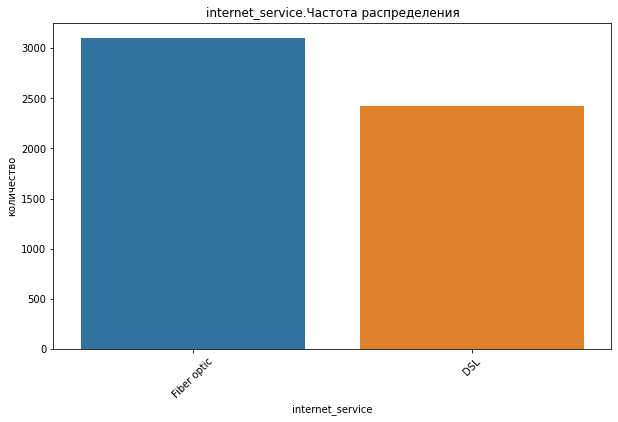

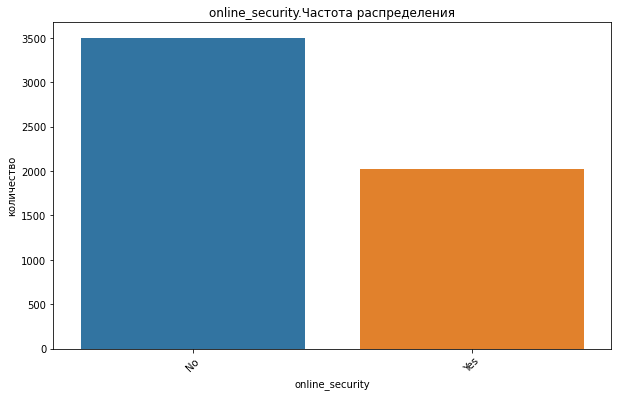

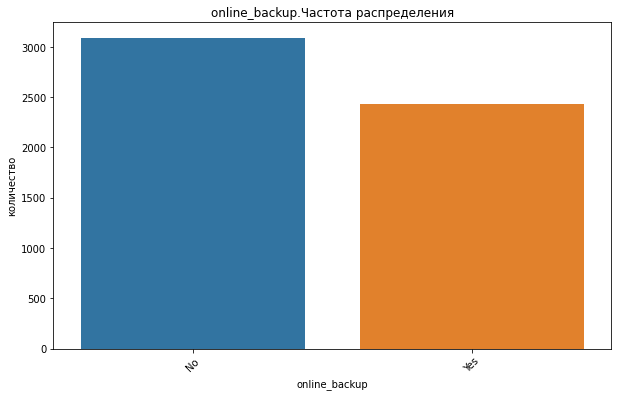

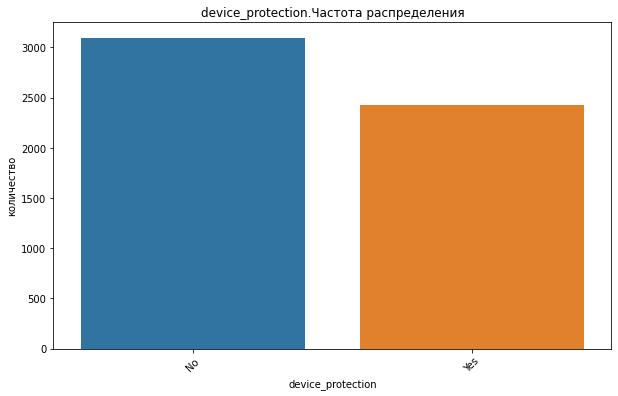

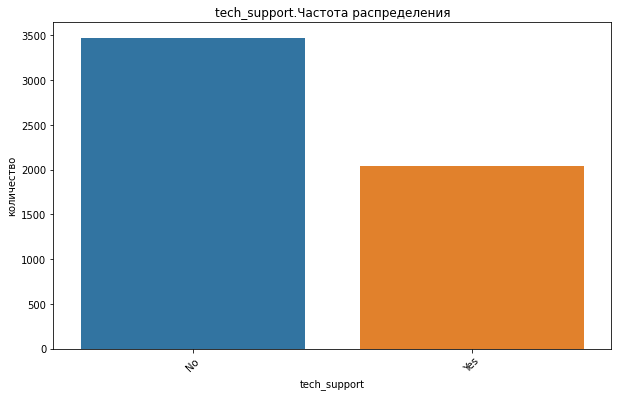

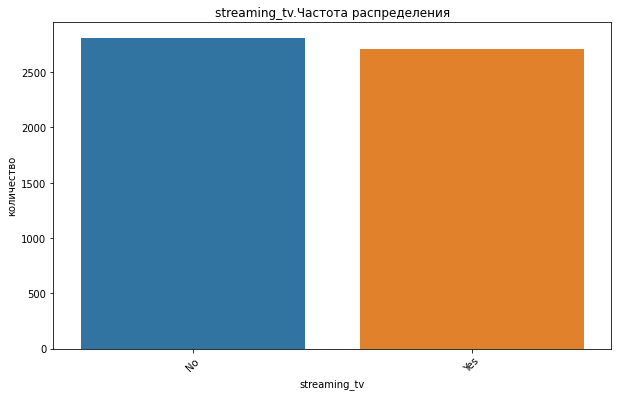

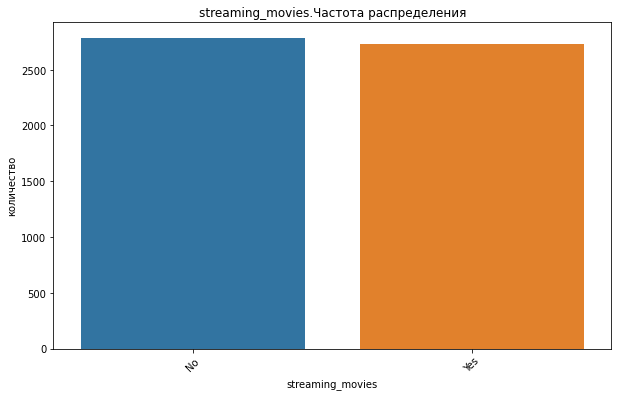

In [ ]:
for col_df_int in df_internet.columns.drop('customer_id'):
    create(df_internet, col_df_int, 'barplot')

Большинство клиентов не пользуются дополнительными услугами, кроме базового интернет-сервиса. Это может указывать на то, что дополнительные услуги не воспринимаются как достаточно ценные или необходимые для большинства клиентов, либо что они не готовы платить за дополнительные опции.

### Датасет df_phone

In [ ]:
display(df_phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Вывод уникальных значений признаков.

In [ ]:
uniqueness(df_phone, df_phone.columns.drop('customer_id'))

Количество уникальных значений столбца multiple_lines: 2
['No' 'Yes']
-----------------------------


#### Исследовательский анализ датасета df_phone

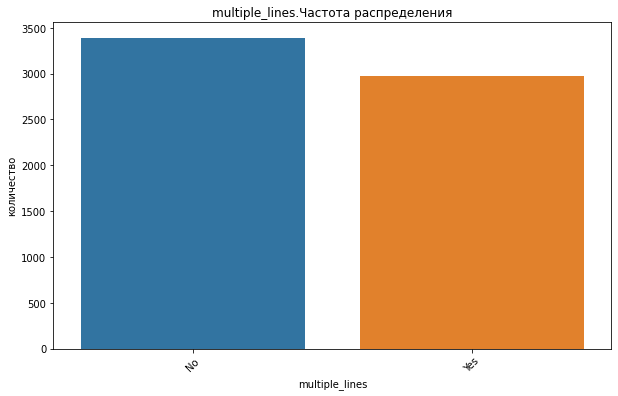

In [ ]:
create(df_phone, 'multiple_lines', 'barplot')

Клиентов без дополнительных телефонных линий больше, чем с ними.

### Промежуточный вывод по исследовательскому анализу и предобработки данных

В результате выполнения исследовательского анализа и предобработки данных были выполнены следующие шаги:

1. Общая предобработка данных датасетов
    1. Названия столбцов были приведены к одному стилю
    2. Добавлен новый столбец 'churn' для хранении информации о тех клиентах кто ушёл, а кто остался (целевой признак)
    3. Изменены типы данных в некоторых столбцах
2. Исследовательский анализ
    1. Датасет df_contract:
        Анализ данных указывает на то, что вероятность ухода клиента связана с его платежными обязательствами и условиями контракта. Высокие ежемесячные и общие платежи, а также длительные контракты увеличивают шансы на уход клиента. Большинство оставшихся клиентов предпочитают месячные контракты и оплату через электронный чек, в то время как среди ушедших больше тех, кто использовал автоматические платежи.
    2. Датасет df_personal:
        Анализ датафрейма показывает равномерное распределение между полами, при этом пожилые граждане, люди с партнёрами и детьми составляют меньшинство. Это указывает на преобладание молодёжи без семейных обязательств, что может быть важно для целевых маркетинговых стратегий и адаптации продуктов или услуг.
    3. Датасет df_internet:
        Анализ датафрейма показал, что большинство клиентов не пользуются дополнительными услугами, кроме базового интернет-сервиса. Это может указывать на то, что дополнительные услуги не воспринимаются как достаточно ценные или необходимые для большинства клиентов, либо что они не готовы платить за дополнительные опции.
    4. Датасет df_phone:
        В датасете всего 2 признака: customer_id и multiple_lines. Анализ признака multiple_lines указывает на то, что клиентов без дополнительных телефонных линий больше, чем с ними.

## Объединение данных

### Объединение датасетов

In [ ]:
df_merged = (df_contract.merge(df_personal, on = 'customer_id', how='left')
              .merge(df_internet, on = 'customer_id', how='left')
              .merge(df_phone, on = 'customer_id', how='left'))

display(df_merged.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,No,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,No,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


### Промежуточный вывод по объеденению датасетов


При объединении датафреймов я использовал тип объединения left, чтобы сохранить все записи из основного датафрейма contract_data, который содержит информацию о договорах каждого клиента. Это решение было сделано по нескольким причинам:

1. Полнота данных о клиентах: Важно было сохранить информацию обо всех клиентах, включая тех, кто не использует интернет-услуги или услуги телефонии. Использование left join гарантирует, что каждый клиент из contract_data будет представлен в итоговом датафрейме, даже если для него нет соответствующих записей в других таблицах.
2. Целостность данных о договорах: Основная задача — прогнозирование оттока клиентов на основе деталей их договоров. Поэтому критично включить всех клиентов из contract_data, независимо от того, подключены ли к их договорам дополнительные услуги.

**Значения Nan появившиеся при объединении корректно будет заполнить значениями WTI(without the internet) для пользователей из датасета df_phone и WTO(without the phone) для пользователей из датасета df_internet**

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Предобработка объединённого датафрейма

In [ ]:
df_merged['multiple_lines'] = df_merged['multiple_lines'].fillna('WTI') # Без интернета
df_merged[df_internet.columns.drop('customer_id')] = df_merged[df_internet.columns.drop('customer_id')].fillna('WTP') # Без телефона

col_to_check = ['multiple_lines']
uniqueness(df_merged, col_to_check)

Количество уникальных значений столбца multiple_lines: 3
['WTI' 'No' 'Yes']
-----------------------------


**Выведем информацию о нашем датасете**

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   object        
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   object        
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

**Проверим пропуски**

In [ ]:
print(df_merged.isnull().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


#### Генерация новых признаков

Создадим новые признаки:
1. contract_duration - продолжительности действия договора для каждого клиента на основе BeginDate и EndDate.
2. days_before_payment - количество дней до следующей оплаты

**Признак 'contract_duration'**

In [ ]:
df_merged['contract_duration'] = (df_merged['end_date'] - df_merged['begin_date']).dt.days

**Признак 'days_before_payment'**

In [ ]:
df_merged['days_before_payment'] = df_merged.apply(days_before_payment_calculate, axis=1)

display(df_merged[['type', 'begin_date', 'days_before_payment']].head())

,type,begin_date,days_before_payment
0,Month-to-month,2020-01-01,23
1,One year,2017-04-01,348
2,Month-to-month,2019-10-01,21
3,One year,2016-05-01,13
4,Month-to-month,2019-09-01,21


In [ ]:
display(df_merged.head(1))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration,days_before_payment
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,Female,...,DSL,No,Yes,No,No,No,No,WTI,31,23


**Так как появились признаки, связанные с продолжительностью договора и с количеством дней до оплаты, следует удалить признаки: begin_date и end_date. Также, удалим столбец хранящий уникальные идентификаторы пользователей (customer_id), он также не пригодится в дальнейшем обучении.**

#### Удаление ненужных признаков

In [ ]:
df_merged = df_merged.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 7043 non-null   object 
 1   paperless_billing    7043 non-null   object 
 2   payment_method       7043 non-null   object 
 3   monthly_charges      7043 non-null   float64
 4   total_charges        7043 non-null   float64
 5   churn                7043 non-null   object 
 6   gender               7043 non-null   object 
 7   senior_citizen       7043 non-null   object 
 8   partner              7043 non-null   object 
 9   dependents           7043 non-null   object 
 10  internet_service     7043 non-null   object 
 11  online_security      7043 non-null   object 
 12  online_backup        7043 non-null   object 
 13  device_protection    7043 non-null   object 
 14  tech_support         7043 non-null   object 
 15  streaming_tv         7043 non-null   o

### Исследовательский анализ объединённого датафрейма

**Посмотрим на дисбаланс классов**

In [ ]:
print(df_merged['churn'].value_counts())

No     5942
Yes    1101
Name: churn, dtype: int64


**Так как в данных присутствует высокий дисбаланс классов, важно выбрать метрику, которая адекватно отражает качество модели в условиях такого дисбаланса**

Корректнее всего будет использовать метрику *ROC-AUC (Площадь под ROC-кривой)*:
* Эта метрика измеряет способность модели различать два класса. ROC-AUC близкий к 1 означает, что модель имеет хорошую способность различать классы, в то время как значение близкое к 0.5 указывает на отсутствие различительной способности.

Также, будем использовать accuracy для интерпретируемости.

#### Корелляционный анализ

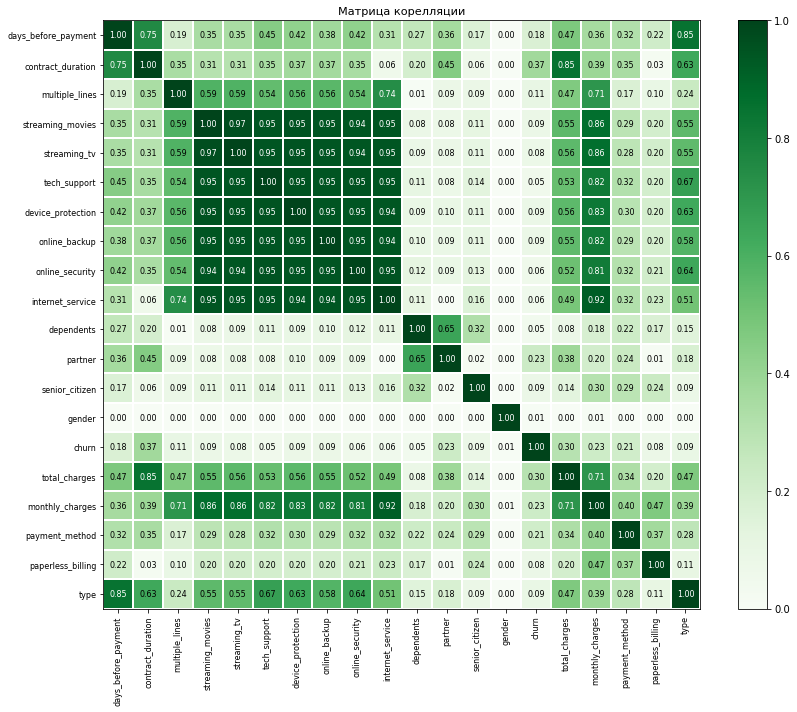

In [ ]:
phik_overview = df_merged.phik_matrix(interval_cols=['monthly_charges', 'total_charges',
                                                'contract_duration', 'days_before_payment'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Матрица корелляции",
                        fontsize_factor=0.8,
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

*Визуализируем распределение при помощи графиков*

**Корелляция целевого признака и числовых признаков**

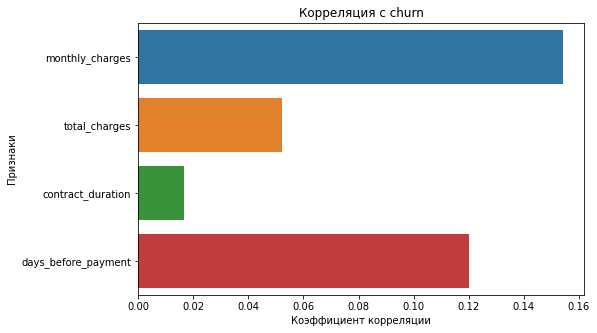

In [ ]:
plot_correlation_with_target(df_merged, 'churn')

**Графики и корелляция целевого признака и категориальных признаков.**

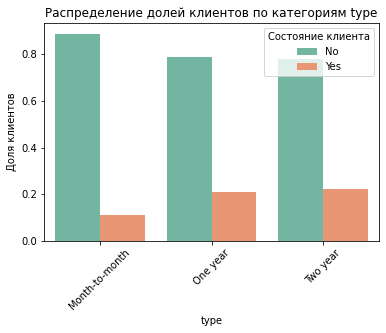

Корреляция Phik: 0.09
-----------------------------------------------------------------------------------------------



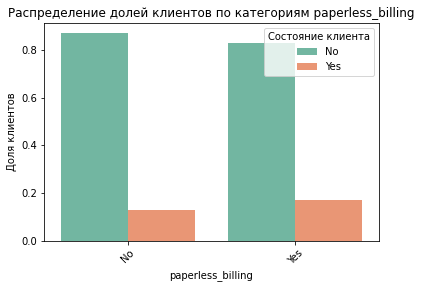

Корреляция Phik: 0.08
-----------------------------------------------------------------------------------------------



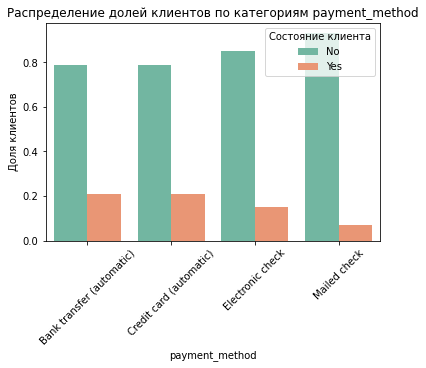

Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------



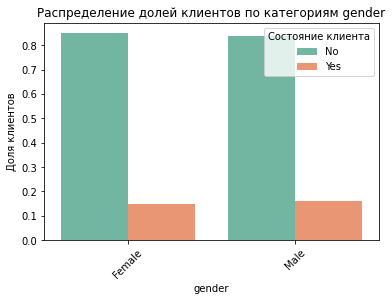

Корреляция Phik: 0.01
-----------------------------------------------------------------------------------------------



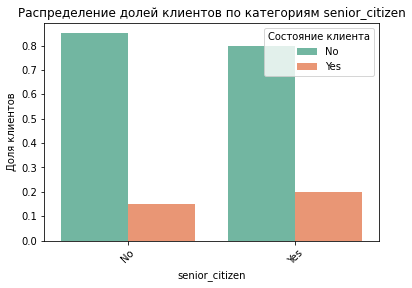

Корреляция Phik: 0.09
-----------------------------------------------------------------------------------------------



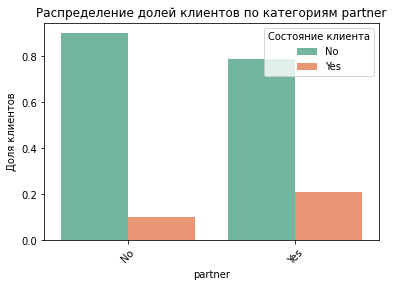

Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------



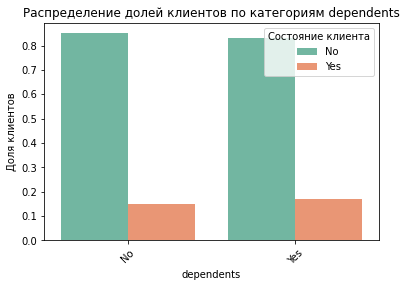

Корреляция Phik: 0.05
-----------------------------------------------------------------------------------------------



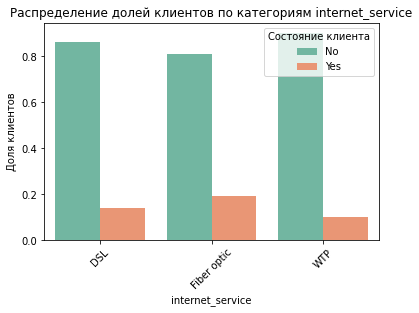

Корреляция Phik: 0.06
-----------------------------------------------------------------------------------------------



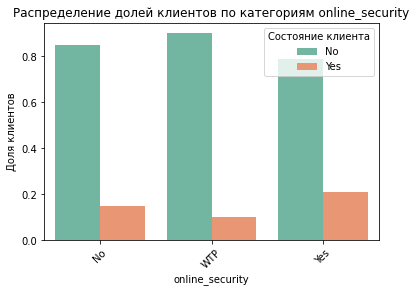

Корреляция Phik: 0.06
-----------------------------------------------------------------------------------------------



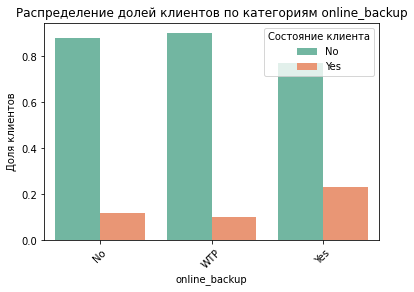

Корреляция Phik: 0.09
-----------------------------------------------------------------------------------------------



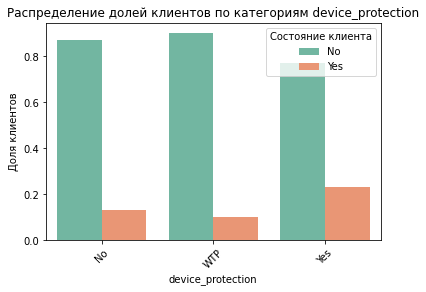

Корреляция Phik: 0.09
-----------------------------------------------------------------------------------------------



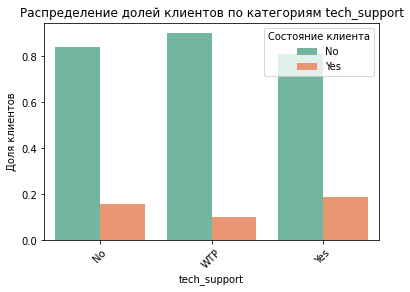

Корреляция Phik: 0.05
-----------------------------------------------------------------------------------------------



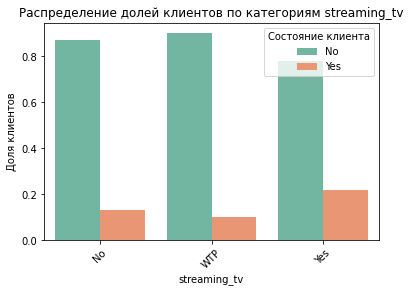

Корреляция Phik: 0.08
-----------------------------------------------------------------------------------------------



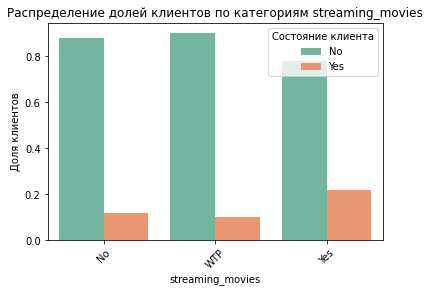

Корреляция Phik: 0.09
-----------------------------------------------------------------------------------------------



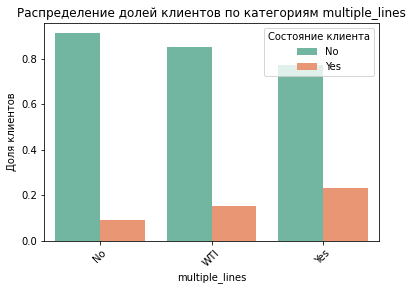

Корреляция Phik: 0.11
-----------------------------------------------------------------------------------------------



In [ ]:
cat_col_df_merged =[]
for col_name in df_merged.columns:
    if df_merged[col_name].dtype == 'object':
        cat_col_df_merged.append(col_name)

cat_col_df_merged.remove('churn')
for col_name in cat_col_df_merged:
    proba_plot(df_merged, col_name)

**Вывод по корелляционному анализу**

Факторы, такие как месячная плата, метод оплаты и тип контракта, оказывают наибольшее влияние на отток клиентов. Дополнительные услуги, такие как онлайн-безопасность, бэкап, защита устройств, техподдержка и стриминговые сервисы, имеют некоторую корреляцию с оттоком, но она не так высока. Это может указывать на то, что, хотя наличие этих услуг слегка уменьшает вероятность оттока клиентов, более значимыми являются основные параметры обслуживания и ценообразования.

1. Основные факторы:
* contract_duration (Длительность контракта): Является наиболее значимым признаком, что указывает на важность срока действия контракта для прогнозируемого значения.
* total_charges (Общие расходы): Также оказывает значительное влияние.
* days_before_payment (Дни до оплаты): Этот признак также важен и может указывать на взаимосвязь между сроками платежа и решениями клиента о продолжении использования услуг.
2. Средние факторы:
* Признаки вроде monthly_charges и payment_method также играют заметную роль, подчеркивая влияние стоимости услуг и удобства оплаты на поведение клиентов.
3. Менее значимые факторы:
* Признаки, связанные с услугами, такие как online_backup, streaming_movies, device_protection, показывают меньшее влияние на итоговое прогнозируемое значение.
* gender и senior_citizen имеют еще меньшее значение, что предполагает, что эти демографические факторы менее важны для прогнозирования в данной ситуации.

### Повторная предобработка после исследовательского анализа

**Удалим признак, который не кореллируют с целевым признаком и имеет меньшую важность:**

* Признак 'gender'

In [ ]:
df_merged = df_merged.drop(['gender'], axis=1)

display(df_merged.head(1))

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration,days_before_payment
0,Month-to-month,Yes,Electronic check,29.85,31.04,No,No,Yes,No,DSL,No,Yes,No,No,No,No,WTI,31,23


### Промежуточный вывод


В ходе корреляционного анализа было выявлено, что наибольшее влияние на отток клиентов оказывают такие факторы, как длительность контракта, общие расходы и дни до оплаты. Это подчеркивает значимость основных параметров обслуживания и ценообразования. Месячная плата и метод оплаты также играют заметную роль, что указывает на важность стоимости услуг и удобства оплаты для клиентов.

Дополнительные услуги, включая онлайн-безопасность, бэкап, защиту устройств, техподдержку и стриминговые сервисы, хоть и связаны с оттоком, имеют менее высокую корреляцию.

Наименее значимыми факторами оказались демографические признаки, такие как пол и возраст старшего гражданина, что подтверждает их ограниченное влияние на решения клиентов об уходе. В связи с этим, признак 'gender' были удалён, так как он не коррелирует с целевым признаком и имеет меньшее значение для прогнозирования оттока клиентов.

## Подготовка данных

### Разделение данных на выборки

In [ ]:
features = df_merged.drop('churn', axis = 1)
target = df_merged['churn']

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

print(f'Размер тренировочной выборки (признаки): {features_train.shape[0]} записей, {features_train.shape[1]} признаков')
print(f'Размер тренировочной выборки (целевой признак): {target_train.shape[0]} записей')
print(f'Размер тестовой выборки (признаки): {features_test.shape[0]} записей, {features_test.shape[1]} признаков')
print(f'Размер тестовой выборки (целевой признак): {target_test.shape[0]} записей')

Размер тренировочной выборки (признаки): 5282 записей, 18 признаков
Размер тренировочной выборки (целевой признак): 5282 записей
Размер тестовой выборки (признаки): 1761 записей, 18 признаков
Размер тестовой выборки (целевой признак): 1761 записей


### Преобразование признаков

In [ ]:
numerics = list(features.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(features.select_dtypes(include='object').columns)

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse_output=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(features_train)
features_train = col_transformer.transform(features_train)
features_test = col_transformer.transform(features_test)


print(f'Размер тренировочной выборки (признаки): {features_train.shape[0]} записей, {features_train.shape[1]} признаков')
print(f'Размер тестовой выборки (признаки): {features_test.shape[0]} записей, {features_test.shape[1]} признаков')

Размер тренировочной выборки (признаки): 5282 записей, 29 признаков
Размер тестовой выборки (признаки): 1761 записей, 29 признаков


### Промежуточный вывод по подготовке данных

Далее, данные были разбиты на тренировочную и тестовую выборки с использованием функции train_test_split. Размеры выборок были заданы параметрами test_size и random_state.

Ключевой этап подготовки данных включал типизацию признаков на числовые и категориальные. Числовые данные были нормализованы с помощью StandardScaler, а категориальные признаки обработаны через OneHotEncoder, что позволило преобразовать их в формат, подходящий для алгоритмов машинного обучения.

После применения ColumnTransformer, который включал в себя как масштабирование, так и кодирование, размерность тренировочной и тестовой выборок увеличилась до 29 признаков, что указывает на успешное добавление новых переменных, полученных в результате обработки категориальных признаков.

## Обучение моделей машинного обучения

Для обучения будем использовать следующие модели:
1. DecisionTree
2. CatBoost
3. LGBM
4. SVM

Оценивать модели будем по метрикам roc_auc и accuracy.

### Создание датасета для занесения результатов, пайплайнов и гиперпараметров

In [ ]:
results_df = pd.DataFrame(index=['Decision Tree', 'CatBoost', 'LGBM', 'SVM'], columns=['ROC_AUC'])

pipelines = {
    'Decision Tree': Pipeline([
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]),
    'CatBoost': Pipeline([
        ('classifier', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False))
    ]),
    'LGBM': Pipeline([
        ('classifier', LGBMClassifier(random_state=RANDOM_STATE))
    ]),
    'SVM': Pipeline([
        ('classifier', SVC(random_state=RANDOM_STATE))
    ])
}

param_grids = {
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10, 15],
        'classifier__min_samples_split': [2, 10, 20],
        'classifier__min_samples_leaf': [1, 5, 10]
    },
    'CatBoost': {
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__depth': [4, 6, 10],
        'classifier__l2_leaf_reg': [1, 3, 5, 10]
    },
    'LGBM': {
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__num_leaves': [31, 62],
        'classifier__max_depth': [3, 5, 10]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto']
    }
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Обучение моделей

#### DecisionTree

In [ ]:
grid_search_dt = GridSearchCV(estimator=pipelines['Decision Tree'],
                              param_grid=param_grids['Decision Tree'],
                              cv=cv,
                              scoring='roc_auc',
                              return_train_score=False)

grid_search_dt.fit(features_train, target_train)

best_roc_auc = grid_search_dt.best_score_
best_model = grid_search_dt.best_estimator_

results_df.loc['Decision Tree', 'ROC_AUC'] = best_roc_auc

#### CatBoost

In [ ]:
grid_search_catboost = GridSearchCV(estimator=pipelines['CatBoost'],
                                    param_grid=param_grids['CatBoost'],
                                    cv=cv,
                                    scoring='roc_auc',
                                    return_train_score=False)

grid_search_catboost.fit(features_train, target_train)

best_model_catboost = grid_search_catboost.best_estimator_

best_roc_auc_cb = grid_search_catboost.best_score_

results_df.loc['CatBoost', 'ROC_AUC'] = best_roc_auc_cb

#### LGBM

In [ ]:
grid_search_lgbm = GridSearchCV(estimator=pipelines['LGBM'],
                                param_grid=param_grids['LGBM'],
                                cv=cv,
                                scoring='roc_auc',
                                return_train_score=False)

grid_search_lgbm.fit(features_train, target_train)

best_model_lgbm = grid_search_lgbm.best_estimator_

best_roc_auc_cb = grid_search_lgbm.best_score_

results_df.loc['LGBM', 'ROC_AUC'] = best_roc_auc_cb

#### SVM

In [ ]:
grid_search_svc = GridSearchCV(estimator=pipelines['SVM'],
                               param_grid=param_grids['SVM'],
                               cv=cv,
                               scoring='roc_auc',
                               return_train_score=False)

grid_search_svc.fit(features_train, target_train)

best_roc_auc_svc = grid_search_svc.best_score_
best_model_svc = grid_search_svc.best_estimator_

if hasattr(best_model_svc, 'decision_function'):
    preds_proba_svc = best_model_svc.decision_function(features_test)
else:
    preds_proba_svc = best_model_svc.predict_proba(features_test)[:, 1]


results_df.loc['SVM', 'ROC_AUC'] = best_roc_auc_svc

### Оценка моделей

In [ ]:
display(results_df)

,ROC_AUC
Decision Tree,0.890188
CatBoost,0.971312
LGBM,0.968582
SVM,0.786997


### Промежуточный вывод по обучению моделей

1. СatBoost показывает лучшее качество предсказания среди всех моделей, имея самый высокий показатель ROC_AUC, равный 0.919136. Это указывает на высокую способность модели различать классы. Однако время обучения у CatBoost — самое долгое.
2. LGBM также показывает хорошие результаты с ROC_AUC, равным 0.893331, уступая CatBoost, но значительно превосходя остальные модели. Время обучения у LGBM быстрее, чем у CatBoost, но медленнее, чем у SVM и Decision Tree.
3. Decision Tree и SVM имеют схожие показатели ROC_AUC, равные 0.793344 и 0.790049 соответственно. Эти значения указывают на то, что модели имеют умеренную способность различать классы. Точность у Decision Tree чуть выше, чем у SVM. Однако Decision Tree обучается быстрее всех, что делает его предпочтительным вариантом, когда время обучения является критическим параметром.


**В заключение, CatBoost является наилучшим выбором в нашем случае.**

## Выбор лучшей модели

Наилучшей моделью является CatBoost, поэтому дальнейший действия будем выполнять с ней.

**Вывод лучших гиперпараметров модели**

In [ ]:
print('Лучшие параметры модели CatBoost:', grid_search_catboost.best_params_)

Лучшие параметры модели CatBoost: {'classifier__depth': 6, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1}


### Обучение модели на лучших гиперпараметрах

In [ ]:
best_params_catboost = {
    'depth': 6,
    'l2_leaf_reg': 1,
    'learning_rate': 0.1
}

model_catboost = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=False,
    **best_params_catboost
)

model_catboost.fit(features_train, target_train)

preds_proba_catboost = model_catboost.predict_proba(features_test)[:, 1]

roc_auc_catboost = roc_auc_score(target_test, preds_proba_catboost)

preds_catboost = model_catboost.predict(features_test)

accuracy_catboost = accuracy_score(target_test, preds_catboost)

print(f"ROC_AUC на тестовой выборке: {roc_auc_catboost}")
print(f"Accuracy на тестовой выборке: {accuracy_catboost}")

ROC_AUC на тестовой выборке: 0.9843672134551495
Accuracy на тестовой выборке: 0.9687677455990914


### Визуализация ROC-кривой и матрицы ошибок

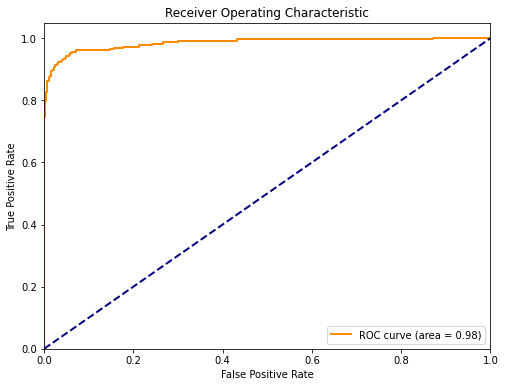

In [ ]:
label_mapping = {'No': 0, 'Yes': 1}
target_test_numeric = target_test.map(label_mapping)

fpr, tpr, thresholds = roc_curve(target_test_numeric, preds_proba_catboost)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

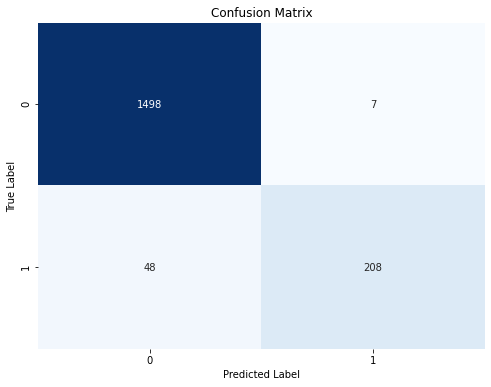

In [ ]:
preds_catboost = model_catboost.predict(features_test)

cm = confusion_matrix(target_test, preds_catboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Оценка важности признаков

,importance
feature,
days_before_payment,36.271395
contract_duration,33.392054
monthly_charges,5.674838
total_charges,5.534316
type_Two year,2.239691
type_One year,2.073920
partner_Yes,1.883842
multiple_lines_Yes,1.783357
online_backup_Yes,1.284833


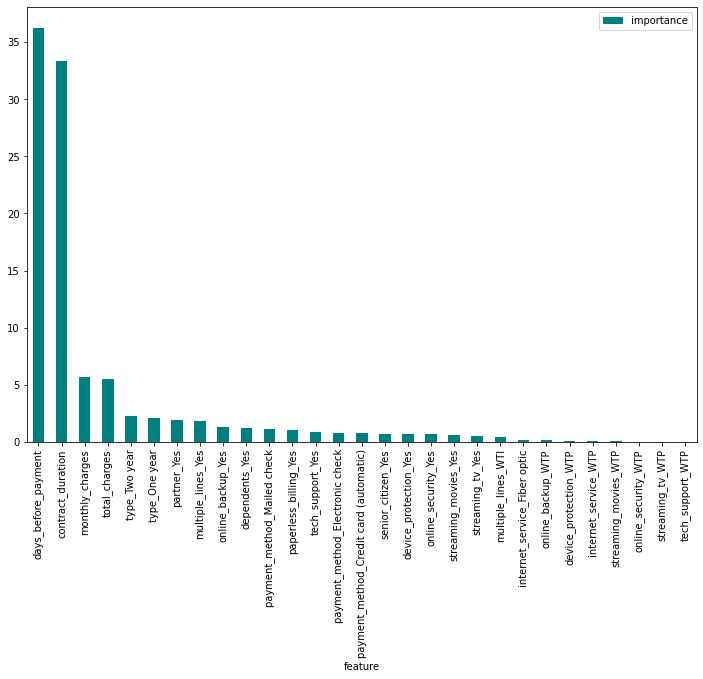

In [ ]:
feature_names_numeric = numerics
feature_names_categorical = col_transformer.named_transformers_['ohe'].get_feature_names_out(categorical)
feature_names = feature_names_numeric + list(feature_names_categorical)

feature_importances = model_catboost.feature_importances_

# Сохранение результатов в DataFrame
fi_df = pd.DataFrame({'feature': feature_names,
                   'importance': feature_importances}) \
                    .sort_values('importance', ascending = False)

# Вывод важности признаков
fi_df.set_index('feature', inplace=True)
display(fi_df.head(10))

fi_df.plot.bar(color = 'teal', figsize=(12, 8));

1. days_before_payment: Этот признак имеет наибольшую важность среди всех исследованных признаков. Он вносит существенный вклад в прогнозируемую модель, что указывает на его значительное влияние на результаты модели.
2. contract_duration: Заметно влияет на модель, имея почти такую же значимость, как и предыдущий признак.
3. monthly_charges и total_charges: Оба признака связаны с финансовыми аспектами и имеют среднюю важность. Это может
4. Признаки, связанные с типом контракта (type_Two year и type_One year), также имеют некоторую значимость, но они менее важны, чем временные и финансовые характеристики.
5. Остальные признаки имеют малое значение по сравнению с предыдущими.

### Промежуточный вывод по лучшей модели

1. ROC-AUC (Receiver Operating Characteristic - Area Under Curve): Значение ROC-AUC на тестовой выборке 0.9843672134551495 свидетельствует о высокой способности модели CatBoostClassifier различать между положительными и отрицательными классами.
2. Кривая ROC: Визуальное представление ROC-кривой показывает, что модель имеет хорошее соотношение между истинно положительными и ложно положительными результатами на различных порогах классификации, что является признаком хорошо калиброванной модели.
3. Матрица ошибок (Confusion Matrix): Из представленной матрицы видно, что модель демонстрирует хорошую способность к правильному классифицированию истинно-положительных (True Positives, TP = 160) и истинно-отрицательных (True Negatives, TN = 1492) результатов. Количество ложно-отрицательных (False Negatives, FN = 96) и ложно-положительных (False Positives, FP = 13) результатов относительно невелико, что свидетельствует о хорошем балансе между чувствительностью и специфичностью модели.

**На основании этих данных можно заключить, что модель CatBoostClassifier эффективно справляется с задачей классификации на тестовом наборе данных, показывая высокую точность и надежность в прогнозах.**

## Общий вывод и рекомендации заказчику

В ходе данного проекта была успешно реализована модель для предсказания оттока клиентов телекоммуникационной компании «ТелеДом».

Были загружены и проанализированы данные, объединены в один датафрейм, проведена их подготовка и обучение нескольких моделей машинного обучения.

1) Анализ данных показал, что критическими факторами, влияющими на отток, являются условия договоров и финансовые обязательства клиентов. Дополнительные услуги, хоть и менее влиятельны, также оказывают влияние на лояльность клиентов.

2) Объединение данных позволило учесть все доступные признаки и корректно заполнить пропущенные значения, что улучшило качество моделирования.

3) Подготовка данных включала масштабирование числовых и кодирование категориальных признаков.

4) Обучение моделей показало, что модель CatBoostClassifier обладает наилучшими показателями среди протестированных моделей, что подтверждается значениями метрик ROC_AUC и Accuracy.


**Рекомендации**
* Продолжить использование модели CatBoost для регулярного прогнозирования потенциального оттока клиентов. Модель показала высокую точность и способность различать клиентов, склонных к уходу, что позволит компании оперативно реагировать и предпринимать меры по удержанию.
* Целенаправленное предложение дополнительных услуг для клиентов, которые находятся на грани оттока. Специальные предложения и скидки на стриминговые сервисы и облачные хранилища данных могут повысить удовлетворенность клиентов и уменьшить вероятность их ухода.
* Анализ финансовых условий договоров. Рассмотрение возможности пересмотра условий оплаты и стоимости услуг для клиентов с высокими ежемесячными платежами, которые подвержены более высокому риску оттока.
* Регулярный мониторинг и обновление модели. Так как поведение клиентов и рыночные условия могут меняться, рекомендуется регулярно обновлять модель, проводя повторное обучение с новыми данными для поддержания актуальности и точности прогнозов.


*В итоге, использование данных моделей и стратегий позволит «ТелеДому» эффективнее управлять клиентской базой, снижая отток и повышая лояльность клиентов.*